In [ ]:
import boto3, os
import pyarrow.parquet as pq
import pandas as pd
import re
import pyspark.sql.functions as f
import numpy as np

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, FloatType, DoubleType, DateType, LongType
from pyspark.sql.functions import explode
from pyspark.sql.functions import col


s3 = boto3.resource('s3')

conf = SparkConf()
conf.set('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.1.2')
conf.set('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider')   
    
spark = SparkSession.builder \
    .config(conf=conf) \
    .appName('DataFrame') \
    .master('local[*]') \
    .getOrCreate()



In [ ]:
%%time

#lista plikow parquet na s3
files_path = []
loc = "s3a://"
i = 0
for obj in s3.Bucket(name='rb-parquet-07012022').objects.all():
    if re.match(".*\.parquet",obj.key):
        plik = os.path.join(obj.bucket_name, obj.key)
        print(loc+plik)
        files_path.append(loc+plik)
        if i == 0:
            data = spark.read.parquet(loc+plik)
            i = 1
        else:
            data = data.union(spark.read.parquet(loc+plik))

In [ ]:
%%time

# zamiast do Pandasa dodajmy pliki do Sparkowego Data Frame

# parDF = spark.read.parquet(files_path[0])
# i = 0
# for file in files_path:
#     if i != 0:
#         newFile = spark.read.parquet(files_path[i])
#         parDF = parDF.union(newFile)
#     i += 1
# parDF.count()

In [ ]:
!aws s3 ls rb-parquet-07012022 --profile=default

In [ ]:
%%time

#import multiprocessing

#multiprocessing.set_start_method('forkserver')
#sklearn dziala z pandasem wiec ladujemy nasze pliki parquet do pandasa

all_files_location = "s3://rb-parquet-07012022/"
#file_location = "s3a://rb-data-05082021/rb_source/parquet/part-00000-d80227f1-ef2f-41b9-ba04-37d112623902-c000.snappy.parquet"
#file_type = "parquet"

#używamy pandasa dlatego że od razu czyta i ładuje wszystkie pliki z danego folderu
data_pd = pq.read_table(all_files_location).to_pandas()

#wywalamy wszystkie wiersze gdzie brakuje(null) abv
#wywalamy tez pozostale niepotrzebne kolumny
data_pd_no_null_abv = data_pd.dropna(subset=["abv"])
data_num = data_pd_no_null_abv.drop(columns=["beer_name", "time", "profilename", "text", "lang"])
data_num



In [6]:
data_pd.isnull().sum()

reviewid            0
beer_name           0
beerid              0
brewerid            0
abv            997656
style               0
appearance          0
aroma               0
palate              0
taste               0
overall             0
time                0
profilename         0
text                0
lang                0
dtype: int64

In [7]:
data_pd_sorted = data_pd.sort_values(by=["reviewid"])
data_pd_sorted

,reviewid,beer_name,beerid,brewerid,abv,style,appearance,aroma,palate,taste,overall,time,profilename,text,lang
144997,1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),0.8,0.6,0.6,0.6,0.65,2006-09-07,hopdog,"On tap at the Springfield, PA location. Poured...",en
289995,2,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),0.8,0.6,0.8,0.7,0.65,2006-09-03,TomDecapolis,On tap at the John Harvards in Springfield PA....,en
434993,3,John Harvards Cristal Pilsner,71716,8481,NaN,Bohemian Pilsener,0.8,0.5,0.6,0.6,0.70,2000-05-19,PhillyBeer2112,"UPDATED FEB 19, 2003 Springfield, PA. I ve nev...",en
579991,4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,0.4,0.4,0.4,0.4,0.40,2006-09-07,TomDecapolis,On tap the Springfield PA location billed as t...,en
724986,5,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,0.4,0.4,0.4,0.4,0.40,2006-09-07,hopdog,"On tap at the Springfield, PA location. Poured...",en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2464957,2899996,Grans UTE pils,101129,2493,4.7,Pale Lager,0.4,0.3,0.4,0.2,0.30,2009-04-29,Finn,"Can 0,5l. Pale golden colored. A small creamy ...",en
2609954,2899997,Grans UTE pils,101129,2493,4.7,Pale Lager,0.6,0.5,0.4,0.5,0.50,2009-04-23,KnutAlbert,Can from REMA 1000. Better than expected. Firm...,en
2754952,2899998,Grans UTE pils,101129,2493,4.7,Pale Lager,0.6,0.5,0.4,0.4,0.45,2009-04-18,larsga,Biggish white head. Light yellow body with lig...,en
2899948,2899999,Grans UTE pils,101129,2493,4.7,Pale Lager,0.6,0.3,0.6,0.4,0.35,2009-04-14,yngwie,"Can. A clear, slightly pale golden beer with a...",en


In [8]:
data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2899949 entries, 0 to 2899948
Data columns (total 15 columns):
 #   Column       Dtype  
---  ------       -----  
 0   reviewid     int32  
 1   beer_name    object 
 2   beerid       int32  
 3   brewerid     int32  
 4   abv          float64
 5   style        object 
 6   appearance   float64
 7   aroma        float64
 8   palate       float64
 9   taste        float64
 10  overall      float64
 11  time         object 
 12  profilename  object 
 13  text         object 
 14  lang         object 
dtypes: float64(6), int32(3), object(6)
memory usage: 298.7+ MB


In [9]:
data_pd.describe().round(2)

,reviewid,beerid,brewerid,abv,appearance,aroma,palate,taste,overall
count,2899949.00,2899949.00,2899949.00,1902293.00,2899949.00,2899949.00,2899949.00,2899949.00,2899949.00
mean,1450005.71,43145.63,2100.38,6.35,0.69,0.64,0.65,0.65,0.66
std,837153.99,43756.66,3059.23,2.10,0.16,0.16,0.17,0.16,0.17
min,1.00,1.00,1.00,0.01,0.20,0.10,0.20,0.10,0.05
25%,725008.00,5011.00,167.00,4.90,0.60,0.60,0.60,0.60,0.60
50%,1450010.00,26777.00,678.00,5.60,0.60,0.70,0.60,0.70,0.70
75%,2175002.00,74651.00,2651.00,7.50,0.80,0.70,0.80,0.80,0.75
max,2900000.00,163404.00,13946.00,57.70,1.00,1.00,1.00,1.00,1.00


In [5]:
#df gdzie jest wiele pozycji dla jednego piwa, czyli są wszystkie recenzje


#musimy zamienic stringi z kolumny style na wartosci binarne

#zamieniamy style na wartości binarne (pd.get_dummies) i dodajemy je do data_num 
df = pd.concat([data_num,pd.get_dummies(data_num['style'], prefix='style')],axis=1)

#usuwamy starą kolumnę style ze stringami
df.drop(['style'],axis=1, inplace=True)

df2 = df.copy()

df_bez_beerid = df2.drop(columns=["reviewid", "brewerid", "beerid"])

#wywalamy beerid i teraz nie bedzie mozna sprawdzic ktore pozycje sa dla tego samego piwa,


df_bez_beerid

#dalej juz uruchamiamy sklearn


,abv,appearance,aroma,palate,taste,overall,style_Abbey Dubbel,style_Abbey Tripel,style_Abt/Quadrupel,style_Altbier,...,style_Specialty Grain,style_Spice/Herb/Vegetable,style_Stout,style_Strong Pale Lager/Imperial Pils,style_Sweet Stout,style_Traditional Ale,style_Vienna,style_Weizen Bock,style_Wheat Ale,style_Zwickel/Keller/Landbier
1,6.7,0.8,0.6,0.8,0.7,0.80,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,6.7,0.6,0.6,0.6,0.6,0.80,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,6.7,0.8,0.6,0.8,0.6,0.60,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,6.7,0.6,0.8,0.6,0.7,0.70,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,6.5,0.8,0.7,0.8,0.7,0.75,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899944,4.7,0.8,0.5,0.6,0.5,0.55,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2899945,4.7,0.8,0.4,0.4,0.4,0.30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2899946,4.7,0.4,0.5,0.6,0.5,0.40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2899947,4.7,0.6,0.3,0.6,0.3,0.15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#ilość stylów

style_list = df_bez_beerid.columns
style_list[6:].shape

(89,)

In [12]:
style_list[6:]

Index(['style_Abbey Dubbel', 'style_Abbey Tripel', 'style_Abt/Quadrupel',
       'style_Altbier', 'style_Amber Ale', 'style_American Dark Lager',
       'style_American Pale Ale', 'style_American Strong Ale',
       'style_Baltic Porter', 'style_Barley Wine', 'style_Belgian Ale',
       'style_Belgian Strong Ale', 'style_Belgian White (Witbier)',
       'style_Berliner Weisse', 'style_Bire de Garde', 'style_Bitter',
       'style_Black IPA', 'style_Bohemian Pilsener', 'style_Brown Ale',
       'style_California Common', 'style_Cider',
       'style_Classic German Pilsener', 'style_Cream Ale', 'style_Doppelbock',
       'style_Dortmunder/Helles', 'style_Dry Stout', 'style_Dunkel',
       'style_Dunkelweizen', 'style_Dunkler Bock', 'style_Eisbock',
       'style_English Pale Ale', 'style_English Strong Ale',
       'style_Foreign Stout', 'style_Fruit Beer', 'style_German Hefeweizen',
       'style_German Kristallweizen', 'style_Golden Ale/Blond Ale',
       'style_Heller Bock', 'style_Ic

In [6]:
#tworzymy dataframe gdzie abv jest puste, czyli tutaj sklearn musi wyznaczy nam abv

#usuwamy wszystkie wiersze gdzie ABV nie jest puste (ma jakąś wartość)
data_null_abv_only = data_pd.loc[data_pd.index.difference(data_pd.dropna(subset=["abv"]).index)]
data_null = data_null_abv_only.drop(columns=["beer_name", "time", "profilename", "text", "lang"])

#musimy zamienic stringi z kolumny style na wartosci binarne

#zamieniamy style na wartości binarne (pd.get_dummies) i dodajemy je do data_null 
df_null2 = pd.concat([data_null,pd.get_dummies(data_null['style'], prefix='style')],axis=1)

#usuwamy starą kolumnę style ze stringami
df_null2.drop(['style'],axis=1, inplace=True)

df_null3 = df_null2.copy()

df_szukane_abv = df_null3.drop(columns=["abv", "reviewid", "brewerid"])
df_szukane_abv

,beerid,appearance,aroma,palate,taste,overall,style_Abbey Dubbel,style_Abbey Tripel,style_Abt/Quadrupel,style_Altbier,...,style_Specialty Grain,style_Spice/Herb/Vegetable,style_Stout,style_Strong Pale Lager/Imperial Pils,style_Sweet Stout,style_Traditional Ale,style_Vienna,style_Weizen Bock,style_Wheat Ale,style_Zwickel/Keller/Landbier
0,91592,0.6,0.6,0.6,0.6,0.60,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,25285,0.8,0.5,0.8,0.5,0.75,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,86866,0.8,0.6,0.8,0.6,0.75,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
29,91689,0.6,0.5,0.6,0.6,0.70,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
30,91689,0.6,0.7,0.6,0.6,0.65,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899933,8111,0.8,0.6,0.6,0.8,0.75,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2899935,83130,0.4,0.4,0.4,0.5,0.60,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2899936,5106,0.8,0.8,1.0,0.8,0.95,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2899937,293,0.6,0.6,0.8,0.6,0.65,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
vvv = data_num.drop(columns=["reviewid", "beerid", "brewerid", "style"])

<AxesSubplot:>

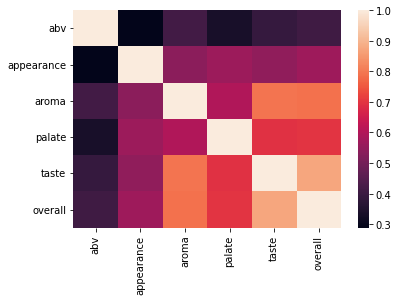

In [7]:
%matplotlib inline

import seaborn as sns

sns.heatmap(vvv.corr())

In [8]:
%%time

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X = df_bez_beerid.drop(columns=["abv"])
y = df_bez_beerid["abv"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

CPU times: user 1.15 s, sys: 314 ms, total: 1.47 s
Wall time: 1.81 s


Mean Squared Error: 1.167811033717095
R2 score: 0.7344535792413039

CPU times: user 6.12 s, sys: 1.44 s, total: 7.55 s
Wall time: 7.88 s


Text(0, 0.5, 'Predictions')

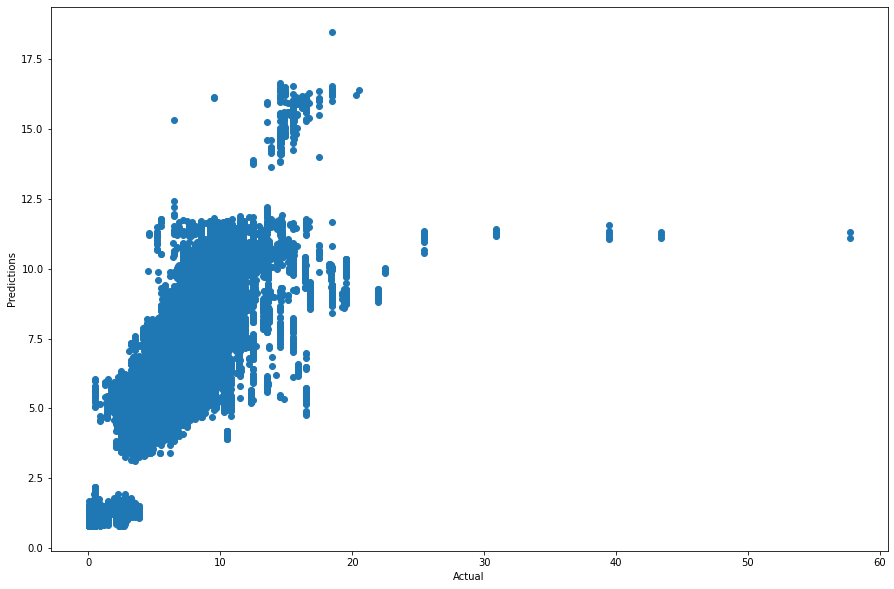

In [9]:
%%time
%matplotlib inline

from matplotlib import pyplot as plt

# Linear regression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

regLr = LinearRegression()
regLr = regLr.fit(X_train,y_train)
predictionsLr = regLr.predict(X_test)

r2scLr = r2_score(y_test, predictionsLr)
msrLr = mean_squared_error(y_test, predictionsLr)


print("Mean Squared Error: " + str(msrLr))
print("R2 score: " + str(r2scLr))
print()


plt.figure(figsize=(15,10))
plt.scatter(y_test, predictionsLr)
plt.xlabel("Actual")
plt.ylabel("Predictions")

In [9]:
%%time

# Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

regR = linear_model.Ridge(alpha=.5)
regR = regR.fit(X_train,y_train)
predictionsR = regR.predict(X_test)

r2scR = r2_score(y_test, predictionsR)
msrR = mean_squared_error(y_test, predictionsR)

print("Mean Squared Error: " + str(msrR))
print("R2 score: " + str(r2scR))
print()

Mean Squared Error: 1.1655868365527156
R2 score: 0.7346083257029515

CPU times: user 1.42 s, sys: 1.05 s, total: 2.47 s
Wall time: 2.55 s


In [10]:
regR.coef_

array([ 0.024485  ,  0.69610072,  0.23529168,  0.04221146,  0.57451256,
       -0.12756567,  1.18708435,  2.68931546, -1.8953305 , -2.03066939,
       -2.40292871, -2.05641881,  1.39415379,  0.28154938,  2.99053446,
       -1.32949149,  1.46963903, -2.15453341, -3.35354158, -0.66094677,
       -3.27774957,  0.15103704, -2.62954983, -2.0188887 , -2.20856331,
       -1.36585866, -2.49564644, -2.25337703,  0.31860078, -2.30619133,
       -2.84275475, -2.30542761, -2.10636897, -0.83347731,  3.69972305,
       -2.33058842, -0.73270047, -0.60374179, -2.24576785, -2.26977468,
       -2.22483927, -2.81374724, -0.69548306,  2.22862145,  2.27213942,
        1.3386433 ,  0.86678808, -1.02766118, -2.11400666, -2.52962534,
       -2.53725877, -2.73476841, -1.46458632, -1.52212588, -5.8895775 ,
        0.0416376 ,  3.88747582, -3.55341779, -1.8076263 ,  0.15544628,
       -2.49066304, -1.54436173, -2.39709716, -1.94421698, -2.19451508,
       -2.36539423, -0.92224991,  8.37155738,  7.38091133, 10.59

Text(0, 0.5, 'Predictions')

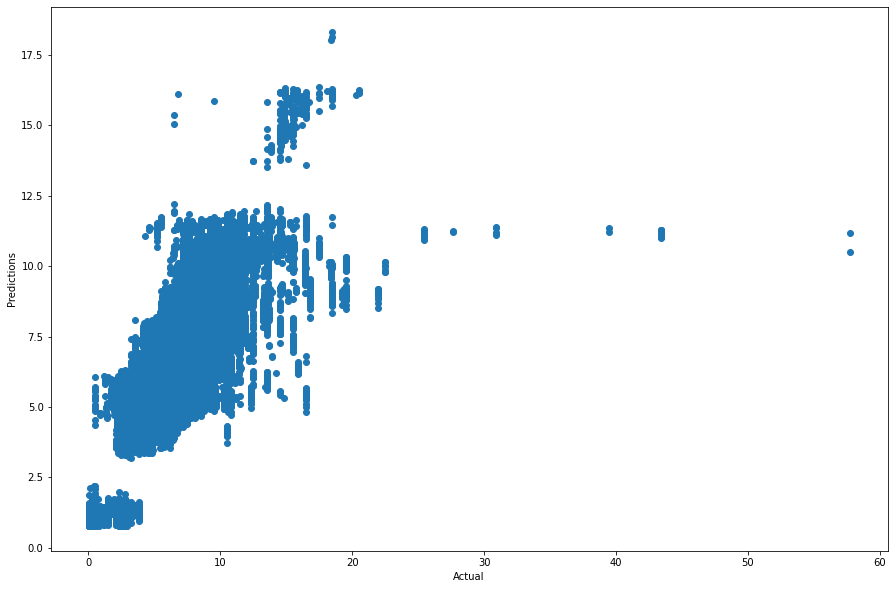

In [11]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.figure(figsize=(15,10))
plt.scatter(y_test, predictionsR)
plt.xlabel("Actual")
plt.ylabel("Predictions")

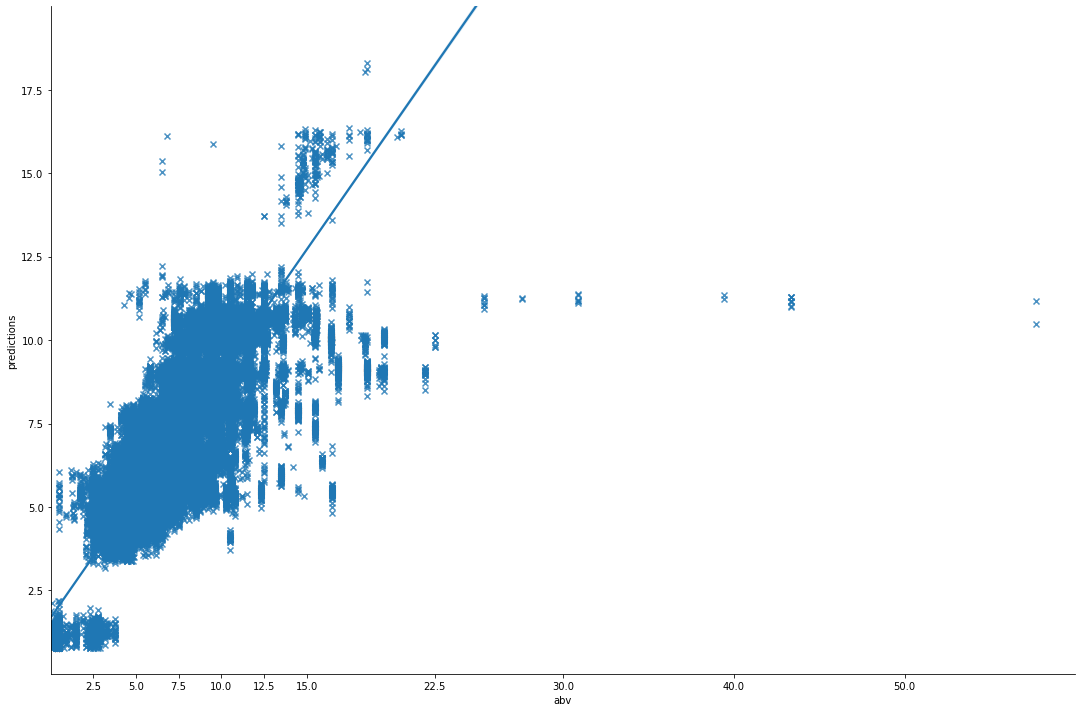

In [12]:
# ten sam wykres tylko w Seaborn
predictionsDF = pd.DataFrame(predictionsR)
predictionsDF = predictionsDF.rename(columns={0: 'predictions'})
yTestDF = pd.DataFrame(y_test)
yTestDF = pd.concat( [yTestDF.reset_index(drop=True), predictionsDF.reset_index(drop=True)], axis=1)

sns.lmplot(data=yTestDF , x="abv", y="predictions", height=10, aspect=1.5, markers=["x"],
           palette="Set2").set(xlim=(0, 60), ylim=(0, 20),xticks=[2.5, 5, 7.5, 10, 12.5, 15, 22.5, 30, 40, 50],
                               yticks=[2.5, 5, 7.5, 10, 12.5, 15, 17.5])



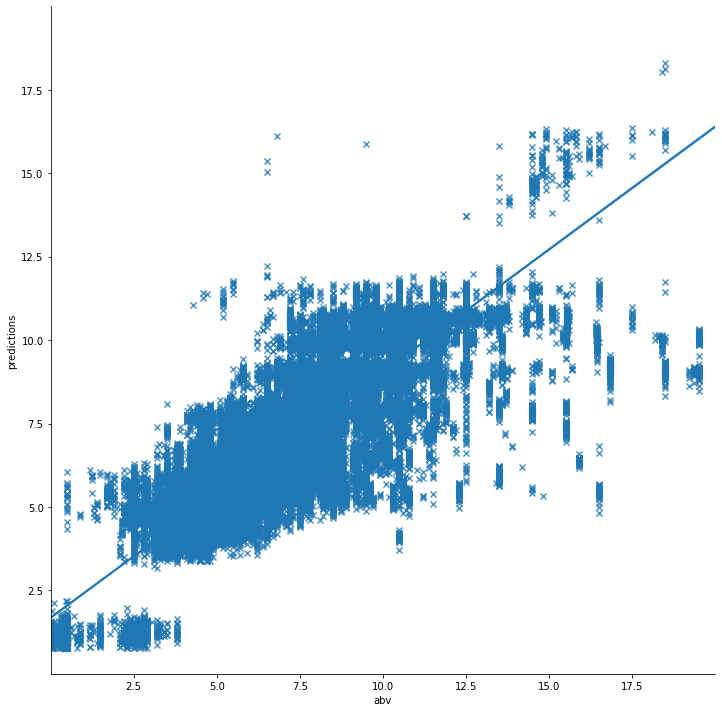

In [14]:
# ten sam wykres ale w granicach 0-20 na obu osiach, żeby różnice były lepiej widoczne
sns.lmplot(data=yTestDF , x="abv", y="predictions", height=10, aspect=1, markers=["x"]).set(xlim=(0, 20), ylim=(0, 20),
           xticks=[2.5, 5, 7.5, 10, 12.5, 15, 17.5], yticks=[2.5, 5, 7.5, 10, 12.5, 15, 17.5])

In [15]:
#możemy zobaczyć jak wyglądają wartości przewidywane w porównaniu do rzeczywistych

avsp = pd.DataFrame({"Actual":y_test, "Predicted":predictionsR, "diff":y_test-predictionsR})
avsp[0:20]

,Actual,Predicted,diff
1264737,9.5,7.279321,2.220679
1851106,5.3,4.540808,0.759192
945207,4.9,5.500702,-0.600702
1066055,4.4,4.950013,-0.550013
1796121,6.5,5.382240,1.117760
232906,8.5,7.069427,1.430573
1153973,5.9,5.432658,0.467342
1903593,6.4,5.526072,0.873928
423597,4.2,5.612473,-1.412473
308526,6.5,5.844481,0.655519


In [ ]:
%%time
%matplotlib inline
from matplotlib import pyplot as plt

#BayesianRidge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

regBR = linear_model.BayesianRidge()
regBR.fit(X_train,y_train)
predictionsBR = regBR.predict(X_test)

r2scBR = r2_score(y_test, predictionsBR)
msrBR = mean_squared_error(y_test, predictionsBR)


print("Mean Squared Error: " + str(msrBR))
print("R2 score: " + str(r2scBR))
print()



plt.figure(figsize=(15,10))
plt.scatter(y_test, predictionsBR)
plt.xlabel("Actual")
plt.ylabel("Predictions")

avsp = pd.DataFrame({"Actual":y_test, "Predicted":predictionsBR, "diff":y_test-predictionsBR})
avsp[0:20]

In [17]:
%%time

# Generalized Linear Regression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import TweedieRegressor

regGLR = TweedieRegressor(power=1, alpha=0.5, link='log')
regGLR.fit(X_train,y_train)
predictionsGLR = regGLR.predict(X_test)

r2scGLR = r2_score(y_test, predictionsGLR)
msrGLR = mean_squared_error(y_test, predictionsGLR)


print("Mean Squared Error: " + str(msrGLR))
print("R2 score: " + str(r2scGLR))
print()

Mean Squared Error: 2.77258201961602e+00
R2 score: 0.36871268511575284

CPU times: user 3.21 s, sys: 452 ms, total: 3.66 s
Wall time: 3.66 s


,Actual,Predicted,diff
1264737,9.5,6.632788,2.867212
1851106,5.3,5.534859,-0.234859
945207,4.9,6.131750,-1.231750
1066055,4.4,5.844838,-1.444838
1796121,6.5,6.235393,0.264607
232906,8.5,6.796658,1.703342
1153973,5.9,6.578325,-0.678325
1903593,6.4,5.618812,0.781188
423597,4.2,6.221209,-2.021209
308526,6.5,6.208795,0.291205


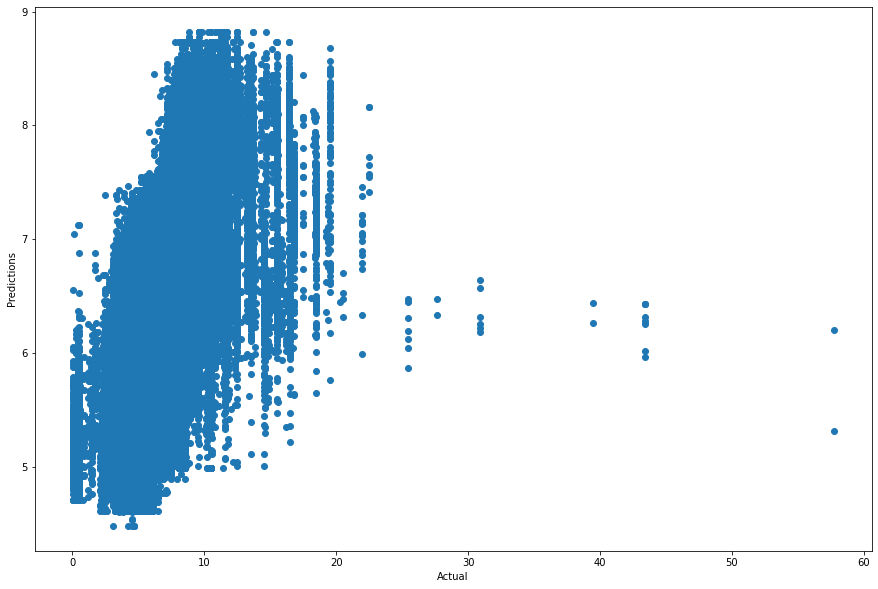

In [18]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.figure(figsize=(15,10))
plt.scatter(y_test, predictionsGLR)
plt.xlabel("Actual")
plt.ylabel("Predictions")

avsp = pd.DataFrame({"Actual":y_test, "Predicted":predictionsGLR, "diff":y_test-predictionsGLR})
avsp[0:20]

Mean Squared Error: 1.2324018147096005
R2 score: 0.7193952687559289

CPU times: user 26.1 s, sys: 1.17 s, total: 27.2 s
Wall time: 27.3 s


Text(0, 0.5, 'Predictions')

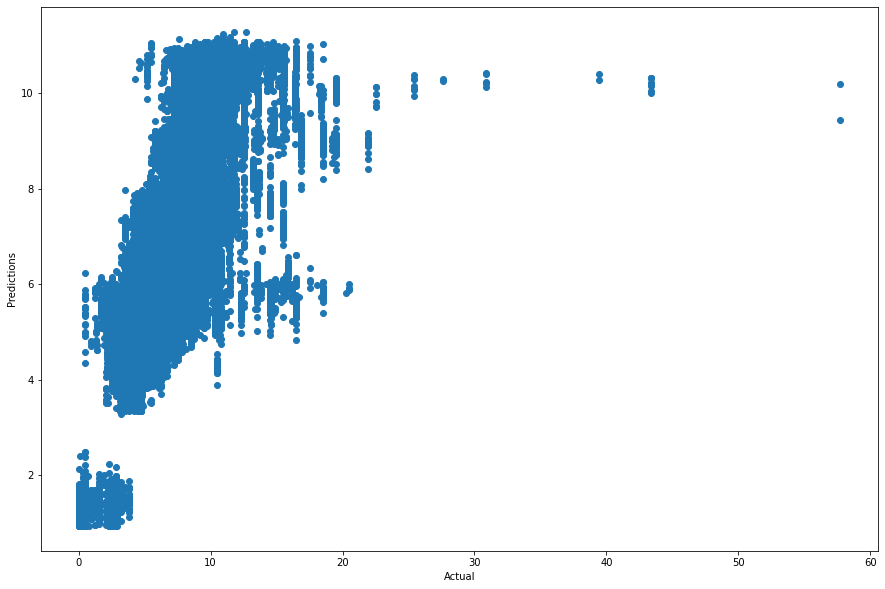

In [19]:
%%time
%matplotlib inline

from matplotlib import pyplot as plt

# lasso

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

regL = linear_model.Lasso(alpha=0.001)
regL = regL.fit(X_train,y_train)
predictionsL = regL.predict(X_test)

r2scL = r2_score(y_test, predictionsL)
msrL = mean_squared_error(y_test, predictionsL)

print("Mean Squared Error: " + str(msrL))
print("R2 score: " + str(r2scL))
print()

plt.figure(figsize=(15,10))
plt.scatter(y_test, predictionsL)
plt.xlabel("Actual")
plt.ylabel("Predictions")

Mean Squared Error: 1.5806258405412448
R2 score: 0.6401083770823379

CPU times: user 6min 22s, sys: 5.84 s, total: 6min 28s
Wall time: 6min 28s


,Actual,Predicted,diff
1264737,9.5,6.372666,3.127334
1851106,5.3,5.192338,0.107662
945207,4.9,5.735604,-0.835604
1066055,4.4,5.217650,-0.817650
1796121,6.5,5.832519,0.667481
232906,8.5,6.698821,1.801179
1153973,5.9,6.343752,-0.443752
1903593,6.4,5.192338,1.207662
423597,4.2,5.830210,-1.630210
308526,6.5,5.577581,0.922419


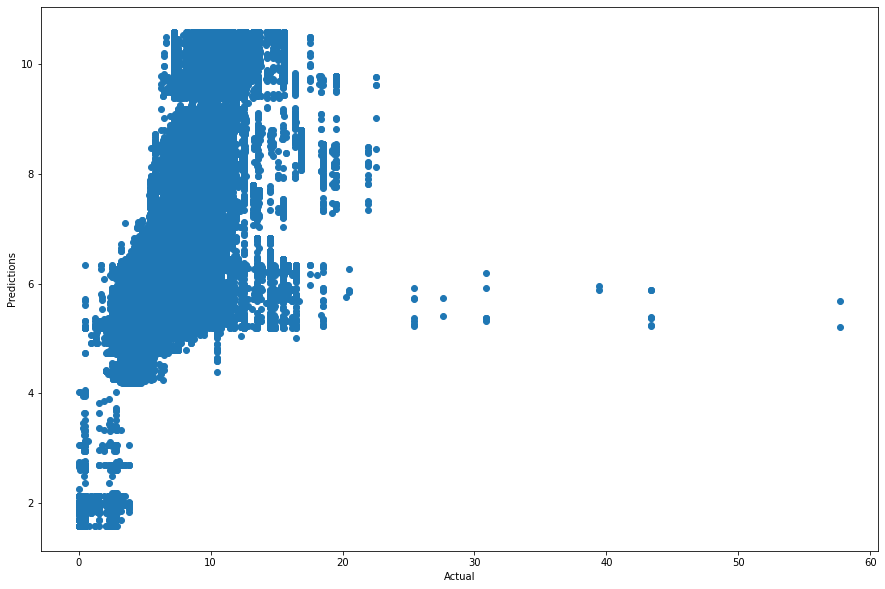

In [20]:
%%time
%matplotlib inline

from matplotlib import pyplot as plt

# GradientBoostingRegressor

import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0,loss='huber').fit(X_train, y_train)
predictionsGBR = est.predict(X_test)

msrGBR = mean_squared_error(y_test, predictionsGBR)
r2scGBR = r2_score(y_test, predictionsGBR)

print("Mean Squared Error: " + str(msrGBR))
print("R2 score: " + str(r2scGBR))
print()

plt.figure(figsize=(15,10))
plt.scatter(y_test, predictionsGBR)
plt.xlabel("Actual")
plt.ylabel("Predictions")

avsp = pd.DataFrame({"Actual":y_test, "Predicted":predictionsGBR, "diff":y_test-predictionsGBR})
avsp[0:20]


Mean Squared Error: 3.3014276842116677
R2 score: 0.24830017532208493

CPU times: user 2min 28s, sys: 2.24 s, total: 2min 30s
Wall time: 2min 30s


,Actual,Predicted,diff
1264737,9.5,6.949527,2.550473
1851106,5.3,5.491917,-0.191917
945207,4.9,6.949527,-2.049527
1066055,4.4,5.491917,-1.091917
1796121,6.5,6.949527,-0.449527
232906,8.5,6.949527,1.550473
1153973,5.9,6.949527,-1.049527
1903593,6.4,5.491917,0.908083
423597,4.2,6.949527,-2.749527
308526,6.5,5.491917,1.008083


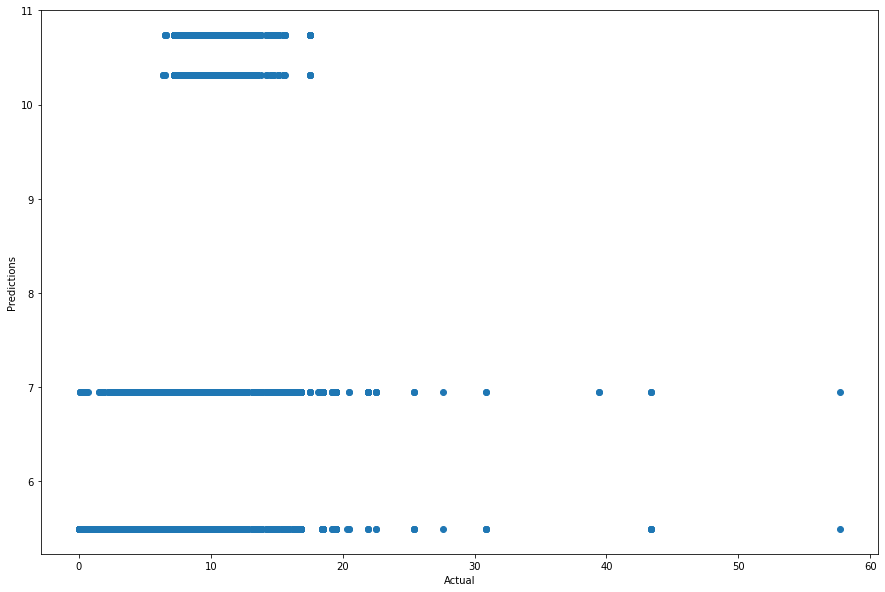

In [21]:
%%time
%matplotlib inline

from matplotlib import pyplot as plt


# RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

regRFR = RandomForestRegressor(max_depth=2, random_state=0)
regRFR.fit(X_train,y_train)

predictionsRFR = regRFR.predict(X_test)

msrRFR = mean_squared_error(y_test, predictionsRFR)
r2scRFR = r2_score(y_test, predictionsRFR)

print("Mean Squared Error: " + str(msrRFR))
print("R2 score: " + str(r2scRFR))
print()

plt.figure(figsize=(15,10))
plt.scatter(y_test, predictionsRFR)
plt.xlabel("Actual")
plt.ylabel("Predictions")

avsp = pd.DataFrame({"Actual":y_test, "Predicted":predictionsRFR, "diff":y_test-predictionsRFR})
avsp[0:20]

Mean Squared Error: 1.2158457440357833
R2 score: 0.7231649092306787

CPU times: user 4min 59s, sys: 9.04 s, total: 5min 8s
Wall time: 5min 8s


,Actual,Predicted,diff
1264737,9.5,7.033427,2.466573
1851106,5.3,4.754673,0.545327
945207,4.9,5.578356,-0.678356
1066055,4.4,5.049759,-0.649759
1796121,6.5,5.548963,0.951037
232906,8.5,6.926050,1.573950
1153973,5.9,5.705716,0.194284
1903593,6.4,5.414609,0.985391
423597,4.2,5.688319,-1.488319
308526,6.5,5.800772,0.699228


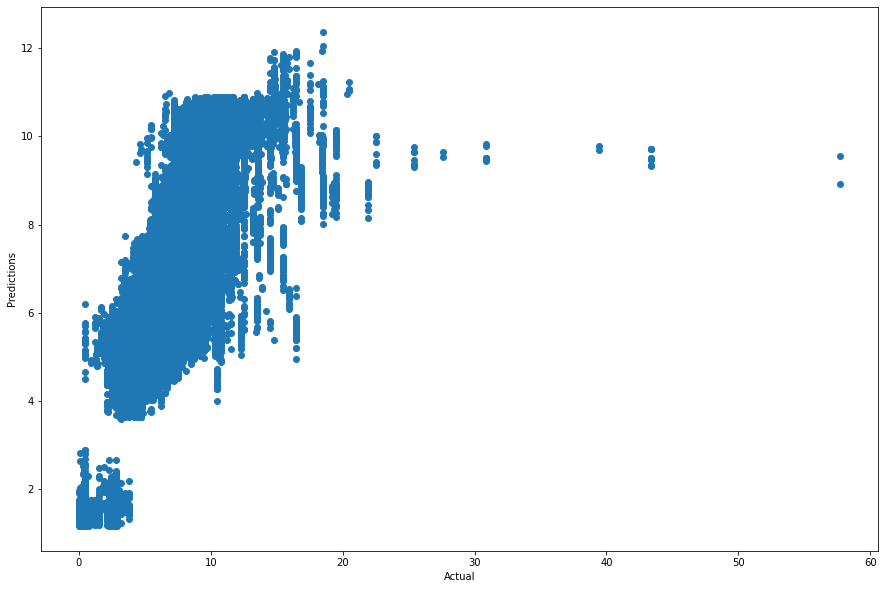

In [22]:
%%time
%matplotlib inline

from matplotlib import pyplot as plt

# Voting Regressor

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from sklearn import linear_model


# Training classifiers
reg1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=0,loss='huber')
#reg2 = RandomForestRegressor(max_depth=2, random_state=0)
reg3 = LinearRegression()
reg4 = linear_model.Ridge(alpha=.5)
reg5 = linear_model.Lasso(alpha=.001)
#ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('lr', reg3), ('ridge', reg4)])
ereg = VotingRegressor(estimators=[('gb', reg1), ('lr', reg3), ('ridge', reg4), ('lasso', reg5)])
ereg = ereg.fit(X_train,y_train)

predictionsVoting = ereg.predict(X_test)


msrV = mean_squared_error(y_test, predictionsVoting)
r2scV = r2_score(y_test, predictionsVoting)

print("Mean Squared Error: " + str(msrV))
print("R2 score: " + str(r2scV))
print()

plt.figure(figsize=(15,10))
plt.scatter(y_test, predictionsVoting)
plt.xlabel("Actual")
plt.ylabel("Predictions")

avsp = pd.DataFrame({"Actual":y_test, "Predicted":predictionsVoting, "diff":y_test-predictionsVoting})
avsp[0:20]

In [ ]:
#wnioski:

#najlepszy i najszybszy model to Ridge i Bayesan Ridge
#największy błąd jest przy piwach z bardzo wysokim ABV, powyżej 15%

In [23]:
#wykorzystujemy nasz model do wyznaczenia brakujących ABV w data frame "df_szukane_abv" który utworzyliśmy wcześniej

brakujace_abv = regR.predict(df_szukane_abv.drop(columns=["beerid"]))
df_brakujace_abv = pd.DataFrame(brakujace_abv)
df_brakujace_abv

,0
0,8.788310
1,5.359434
2,5.680182
3,5.727813
4,5.838307
...,...
997651,5.604966
997652,7.764411
997653,5.953205
997654,10.515985


In [ ]:
#uzupełnienie danych
#już mamy brakujące ABV więc trzeba je teraz dodać do bazy
#jako że możemy mieć wiele recenczji dla jednej pozycji to możemy mieć również różne ABV,
#trzeba uśrednić i wstawić do bazy

In [24]:

df_brakujace_abv2 = pd.concat([df_brakujace_abv, df_szukane_abv["beerid"].reset_index(),],axis=1)
df_brakujace_abv_dla_konkretnej_pozycji = df_brakujace_abv2.groupby(df_brakujace_abv2["beerid"]).mean()
df_brakujace_abv_dla_konkretnej_pozycji = df_brakujace_abv_dla_konkretnej_pozycji.drop(columns=["index"]).reset_index()
df_brakujace_abv_dla_konkretnej_pozycji = df_brakujace_abv_dla_konkretnej_pozycji.set_axis(["beerid", "abv"], axis=1)
df_brakujace_abv_dla_konkretnej_pozycji["abv"] = df_brakujace_abv_dla_konkretnej_pozycji["abv"].round(1)
df_brakujace_abv_dla_konkretnej_pozycji

,beerid,abv
0,2,5.0
1,3,6.7
2,15,5.4
3,21,4.3
4,27,4.7
...,...,...
48238,163383,10.0
48239,163399,5.5
48240,163401,10.3
48241,163403,9.2


In [ ]:
#zapisujemy do csv żeby można było dodać to do bazy danych w Athena
#df_brakujace_abv_dla_konkretnej_pozycji.to_csv("brakujace_abv.csv")

In [25]:
%%time

#join df_szukane_abv z df_brakujace_abv_dla_konkretnej_pozycji po beerid
data_null2 = data_null_abv_only.drop(columns=["abv"])
df_uzupełnione_abv = pd.merge(data_null2,df_brakujace_abv_dla_konkretnej_pozycji,how='left',on='beerid',validate='many_to_many')
df_uzupełnione_abv

CPU times: user 545 ms, sys: 144 ms, total: 689 ms
Wall time: 694 ms


,reviewid,beer_name,beerid,brewerid,style,appearance,aroma,palate,taste,overall,time,profilename,text,lang,abv
0,20,Barley Island Barrel-Aged Count Hopula,91592,3228,Imperial/Double IPA,0.6,0.6,0.6,0.6,0.60,2008-08-24,vyvvy,GTMW 08 on cask - Pours bronze orang with a mi...,en,8.9
1,440,Barley Island Belgian Witbier,25285,3228,Belgian White (Witbier),0.8,0.5,0.8,0.5,0.75,2007-05-04,MI2CA,pint at BI - Aroma is yeasty with sharp spice ...,en,5.3
2,580,Barley Island Bourbon Barrel-Aged Raspberry Oa...,86866,3228,Sweet Stout,0.8,0.6,0.8,0.6,0.75,2008-04-28,MI2CA,Cask at the brewery - I must first mention tha...,en,5.6
3,600,Barley Island Beastie Barrel Stout,91689,3228,Stout,0.6,0.5,0.6,0.6,0.70,2008-12-06,railcat1,This was a very drinkable stout but kinda thin...,en,5.9
4,620,Barley Island Beastie Barrel Stout,91689,3228,Stout,0.6,0.7,0.6,0.6,0.65,2008-08-18,kp,"UPDATED MAY 9, 2009 Name BA Oatmeal Stout Date...",en,5.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997651,2899699,Dieu du Ciel Rsurrection,8111,364,Porter,0.8,0.6,0.6,0.8,0.75,2005-01-18,Goldorak,"Sampled on cask, but usually offered through t...",en,5.7
997652,2899739,Cicc Coc Birra di Natale,83130,7303,Scotch Ale,0.4,0.4,0.4,0.5,0.60,2008-01-18,LordCorkscrew,Laspetto spaventosamente lo stesso della bitte...,it,7.8
997653,2899759,King and Barnes Old Porter,5106,54,Porter,0.8,0.8,1.0,0.8,0.95,2000-09-23,BudMan,"excellent beer, all around great beer.",en,5.6
997654,2899779,King and Barnes Christmas Ale,293,54,Barley Wine,0.6,0.6,0.8,0.6,0.65,2007-09-01,kp,"UPDATED JAN 17, 2009 Name Christmas Date July ...",en,10.6


In [26]:
%%time

#caly dataset z uzupełnionym abv

df_full = pd.concat([data_pd_no_null_abv, df_uzupełnione_abv], ignore_index=True)
df_full = df_full.sort_values(by=['reviewid'])
df_full

CPU times: user 893 ms, sys: 272 ms, total: 1.16 s
Wall time: 1.16 s


,reviewid,beer_name,beerid,brewerid,abv,style,appearance,aroma,palate,taste,overall,time,profilename,text,lang
95124,1,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),0.8,0.6,0.6,0.6,0.65,2006-09-07,hopdog,"On tap at the Springfield, PA location. Poured...",en
190266,2,John Harvards Simcoe IPA,63836,8481,5.4,India Pale Ale (IPA),0.8,0.6,0.8,0.7,0.65,2006-09-03,TomDecapolis,On tap at the John Harvards in Springfield PA....,en
2051884,3,John Harvards Cristal Pilsner,71716,8481,4.8,Bohemian Pilsener,0.8,0.5,0.6,0.6,0.70,2000-05-19,PhillyBeer2112,"UPDATED FEB 19, 2003 Springfield, PA. I ve nev...",en
380484,4,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,0.4,0.4,0.4,0.4,0.40,2006-09-07,TomDecapolis,On tap the Springfield PA location billed as t...,en
475621,5,John Harvards Fancy Lawnmower Beer,64125,8481,5.4,Klsch,0.4,0.4,0.4,0.4,0.40,2006-09-07,hopdog,"On tap at the Springfield, PA location. Poured...",en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1616906,2899996,Grans UTE pils,101129,2493,4.7,Pale Lager,0.4,0.3,0.4,0.2,0.30,2009-04-29,Finn,"Can 0,5l. Pale golden colored. A small creamy ...",en
1711993,2899997,Grans UTE pils,101129,2493,4.7,Pale Lager,0.6,0.5,0.4,0.5,0.50,2009-04-23,KnutAlbert,Can from REMA 1000. Better than expected. Firm...,en
1807118,2899998,Grans UTE pils,101129,2493,4.7,Pale Lager,0.6,0.5,0.4,0.4,0.45,2009-04-18,larsga,Biggish white head. Light yellow body with lig...,en
1902292,2899999,Grans UTE pils,101129,2493,4.7,Pale Lager,0.6,0.3,0.6,0.4,0.35,2009-04-14,yngwie,"Can. A clear, slightly pale golden beer with a...",en


In [ ]:
#zapisujemy do csv żeby można było dodać to do bazy danych w Athena
df_full.to_csv("ratebeer_wabv.csv")

In [ ]:
import pickle

#zapisanie modelu do pliku:
filename = "abv_regression_model.sav"
pickle.dump(regR, open(filename, 'wb'))

In [ ]:
#wczytanie modelu:

# filename = "abv_regression_model.sav"
# loaded_model = pickle.load(open(filename, 'rb'))

# predictions_loaded_model = loaded_model.predict(X_test)
# result = r2_score(y_test, predictions_loaded_model)
# print(result)
